# <font color=00008b>WWU CS Mentors Machine Learning Workshop</font>
#### _By Robin Cosbey and Josh Myers-Dean_

## What we will accomplish in this exercise 
- Learn how to read in a CSV and do some exploratory data analysis
- Build a decision tree model from scratch
- Evaluate our model

### Exploratory Data Analysis
First we will read in a csv file containing information about different species of iris flowers

In [1]:
'''
Pandas is a great library for data manipulation and visualizations,
here we read in the csv and represent it as a dataframe (df). I like to think
of these as fancy dictionaries.
'''

import pandas as pd
df = pd.read_csv("iris.csv")
df.head() # allows us to peak at the first 5 rows of data

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Our data has 4 different features we can use and seem to be labelled by what class of iris they are. <br />
Now that we've got a sneak peek of our data, let's try and see what else we can find out about it before we move on to our model!

In [2]:
print("Dataframe Shape: ", df.shape,"\n")
print("Summary Statistics:\n\n", df.describe())

Dataframe Shape:  (150, 5) 

Summary Statistics:

        sepal-length  sepal-width  petal-length  petal-width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


Awesome! So now we have some useful information about the dataset we are working with. We can think of our dataset as a 150x5 matrix, or simply view it as a CSV with 150 entries with each entry having 5 features.
<br /> 
<br />
The summary statistics give us a view into how the data is distributed, let's take a more visual look at our data.
You can get pretty creative in your EDA visualizations, but for now we will create a simple boxplot showing our summary statistics using the library matplotlib.

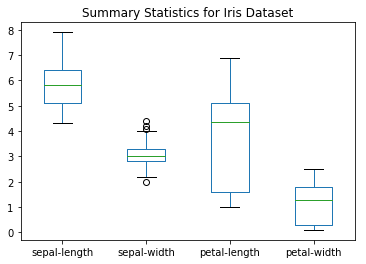

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = df.boxplot(grid=False)
ax.set_title("Summary Statistics for Iris Dataset")
plt.show()

Now we have a peek at the overall statistics our data, but what we are really interested in is how each class differs from each other, so let's visualize that as well.

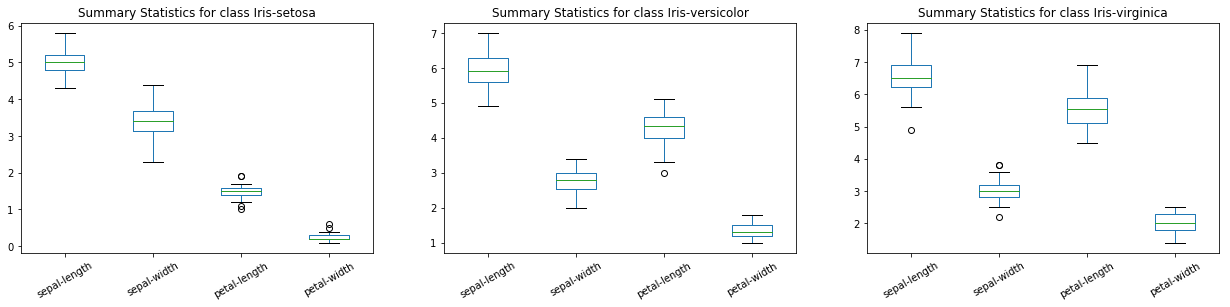

In [4]:
'''
Here we create a few different dataframes, each representing a specific class. unique gives us each individual class
and then we create a seperate dataframe for each class to be plotted as a boxplot.
'''
unique = df['class'].unique()
class1 = df[df['class'] == unique[0]]
class2 = df[df['class'] == unique[1]]
class3 = df[df['class'] == unique[2]]
# There are 3 classes so we want one row of 3 columns 
fig, axes = plt.subplots(nrows=1, ncols=3)
ax1 = class1.boxplot(ax=axes[0], grid=False, rot=30)
ax2 = class2.boxplot(ax=axes[1], grid=False, rot=30)
ax3 = class3.boxplot(ax=axes[2], grid=False, rot=30)
ax1.set_title("Summary Statistics for class {}".format(unique[0]))
ax2.set_title("Summary Statistics for class {}".format(unique[1]))
ax3.set_title("Summary Statistics for class {}".format(unique[2]))
'''
this is straight from the matplotlib documentation to make subplots a 
bit prettier, I adjusted the 'right' parameter
'''
plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 2.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.2,   # the amount of width reserved for blank space between subplots
    hspace = 0.2
)
plt.show()

As we talked about, sometimes data can be biased so let's make sure that we have a relatively even distribution of classes.

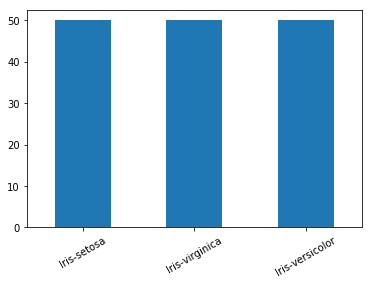

In [5]:
df['class'].value_counts().plot.bar(rot=30)

Excellent! Our 3 classes are balanced quite well. We did this by plotting a value counts of of the "class" column from our dataframe, represented as a bar plot.

<br />
Also notice how we didn't have to call a matplotlib function explicitly? That's because with pandas you can call numpy (numerical python) and matplotlib functions from within your current dataframe object! (Also note that the image was displayed without the plt.show() call, this is a IPython notebook specific thing)

<br />
<br />
Now the only problem is that our class values are not numerical values! This will cause our classifier to spit out an error so let's treat each class as a a numerical value using label encoding. (Note label encoding does have it's pitfalls but will work for our use case)

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['class'])
df['class'] = le.transform(df['class'])
df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
df.tail()

,sepal-length,sepal-width,petal-length,petal-width,class
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


### Building Our Model
Now that we have had a good peak at our data, let's start constructing a model! We want to be able to predict a category, which is a discrete value, so let's go with a decision tree!

Technical | Non-Technical 
- | - 
![alt text](dt.png "A picture of a decision tree") | ![alt text](decision.tree.png "A picture of a decision tree")

## A few things before we start

### Loss and gain functions
#### Loss
- Entropy can be thought as the measure of randomness in the data. The higher the entropy the harder it is to draw conclusions about the data, so we want to __minimize our loss function__.
- Entropy is represented as $E(S)=\sum_{i=1}^{c}-p_ilog_2(p_i)$ where $p_i$ is the frequentist probability of class 'i' and $c$ is the number of classes
- If the data is homogeneous then entropy will be zero, if the data is equally divided across all classes we will start with an entropy of 1
- In our case, since we have an even number of classes our entropy is $-\frac{1}{3}log_2(\frac{1}{3})-\frac{1}{3}log_2(\frac{1}{3})-\frac{1}{3}log_2(\frac{1}{3}) \approx 1$
- Our decision tree results in a leaf node whenever entropy is 0 (when the algoirthm decides on a class), if a node has entropy $> 0$, the node will require further splitting. So in essence, entropy controls how our tree decides to split.

#### Gain
- Information gain tells us how important a given attribute of a feature vector is. (i.e. Sepal Width)
- We want to __maximize gain__ in order to find the most useful feature vector to discriminate between classes.
- Information gain is represented as $IG(parent, children)=E(parent)-avg(E(children))$

### Fitting vs Prediction
![alt text](three-fits.png "Examples of fitting")

#### Fit
In supervised learning, fitting is how we "train" our model to associate data with given labels. In essence, fitting a model is measuring how well the model generalizes to similiar data that the model was trained on. 

#### Predict
Prediction comes into play when we want to see how well our model trained: a good metric for a balanced dataset would be accuracy. We can measure accuracy by feeding our model unlabelled data and then compare our models label outputs to the ground truth labels, the more our model gets right, the higher the accuracy

__Constructing the 2 different node classes__

In [8]:
import numpy as np
''' 
We will be building our model using pure numpy so we only need this import for now 
Here we build the interior and leaf nodes for our tree
'''

class Node:
    def __init__(self, left, right, rule):
        '''
        Create a node for our tree
        '''
        self.left = left
        self.right = right
        self.feature = rule[0]
        self.threshold = rule[1]


class Leaf:
    def __init__(self, value):
        """
        `value` is an array of class probabilities if classifier is True, else
        the mean of the region and since we want to classify, this will be true.
        """
        self.value = value

__Building the tree__

In [9]:
"""
Here is where we will be building our actual model
"""
class DecisionTree:
    # init is the initial values of the object when constructed
    def __init__(
        self,
        classifier=True,
        max_depth=None,
        n_feats=None,
        criterion="entropy",
        seed=None,
    ):
        """
        A decision tree model for regression and classification problems.
        Parameters
        ----------
        classifier : bool
            Whether to treat target values as categorical (classifier =
            True) or continuous (classifier = False). Default is True.
        max_depth: int or None
            The depth at which to stop growing the tree. If None, grow the tree
            until all leaves are pure. Default is None.
        n_feats : int
            Specifies the number of features to sample on each split. If None,
            use all features on each split. Default is None.
        criterion : {'mse', 'entropy', 'gini'}
            The error criterion to use when calculating splits. When
            `classifier` is False, valid entries are {'mse'}. When `classifier`
            is True, valid entries are {'entropy', 'gini'}. Default is
            'entropy'.
        seed : int or None
            Seed for the random number generator. Default is None.
        """
        if seed:
            np.random.seed(seed)
        self.depth = 0
        self.root = None

        self.n_feats = n_feats
        self.criterion = criterion
        self.classifier = classifier
        self.max_depth = max_depth if max_depth else np.inf

        if not classifier and criterion in ["gini", "entropy"]:
            raise ValueError(
                "{} is a valid criterion only when classifier = True.".format(criterion)
            )
        if classifier and criterion == "mse":
            raise ValueError("`mse` is a valid criterion only when classifier = False.")

            
    """
    Here is where we train our model to recognize similiar data to the data that we supplied
    """
    def fit(self, X, Y):
        """
        Fit a binary decision tree to a dataset.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features, for us
            this is (150,5) as seen before.
            
        Y : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            An array of integer class labels for each example in `X` if
            self.classifier = True, otherwise the set of target values for
            each example in `X`.
        """
        self.n_classes = max(Y) + 1 if self.classifier else None # account for 0 indexing
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow(X, Y)

    def predict(self, X):
        """
        Use the trained decision tree to classify or predict the examples in `X`.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features
        Returns
        -------
        preds : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            The integer class labels predicted for each example in `X` if
            self.classifier = True, otherwise the predicted target values.
        """
        # returns the highest class probability
        return np.array([self._traverse(x, self.root) for x in X])

    def predict_class_probs(self, X):
        """
        Use the trained decision tree to return the class probabilities for the
        examples in `X`.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features
        Returns
        -------
        preds : :py:class:`ndarray <numpy.ndarray>` of shape `(N, n_classes)`
            The class probabilities predicted for each example in `X`.
        """
        assert self.classifier, "predict_class_probs undefined for classifier = False"
        # traverse the tree for each iris in the set to find out the class prob
        return np.array([self._traverse(x, self.root, prob=True) for x in X])
    
    
    # create new branches/leaves
    def _grow(self, X, Y):
        # if all labels are the same, return a leaf
        if len(np.unique(Y)) == 1:
            if self.classifier:
                prob = np.zeros(self.n_classes) # create a 1x1 array
                prob[Y[0]] = 1.0 # only one class so can only predict one class
            return Leaf(prob) if self.classifier else Leaf(Y[0])

        
        # if we have reached max_depth, return a leaf
        if self.depth >= self.max_depth:
            v = np.mean(Y, axis=0)
            if self.classifier:
                v = np.bincount(Y, minlength=self.n_classes) / len(Y) 
                '''
                 num occurences of each class in Y divided by the length of Y
                '''
            return Leaf(v)

        n, m = X.shape # rows and cols of X
        self.depth += 1
        feat_idxs = np.random.choice(m, self.n_feats, replace=False)
        ''' 
        Here we pick n_feats random numbers from numbers in range(m), this is where a 
        seed would have an impact
        '''

        # greedily select the best split according to `criterion`
        feat, thresh = self._segment(X, Y, feat_idxs)
        l = np.argwhere(X[:, feat] <= thresh).flatten()
        r = np.argwhere(X[:, feat] > thresh).flatten()
        # grow the children that result from the split, Recursion!!!
        left = self._grow(X[l, :], Y[l])
        right = self._grow(X[r, :], Y[r])
        return Node(left, right, (feat, thresh))

    
    '''
    These next 2 functions are a little wild but what is important to know is that they are used to
    calculate the "rule" of the split in which the tree will branch. 
    Rules generally have the form, if condition1 and condition2 and condition3 then outcome.
    '''
    def _segment(self, X, Y, feat_idxs):
        """
        Find the optimal split rule (feature index and split threshold) for the
        data according to `self.criterion`.
        """
        best_gain = -np.inf
        split_idx, split_thresh = None, None
        for i in feat_idxs:
            vals = X[:, i]
            levels = np.unique(vals)
            thresholds = (levels[:-1] + levels[1:]) / 2 if len(levels) > 1 else levels
            gains = np.array([self._information_gain(Y, t, vals) for t in thresholds])

            if gains.max() > best_gain:
                split_idx = i
                best_gain = gains.max()
                split_thresh = thresholds[gains.argmax()]

        return split_idx, split_thresh
    
    # we want to maximize this
    def _information_gain(self, Y, split_thresh, feat_values):
        """
        Compute the information gain associated with a given split.
        IG(split) = loss(parent) - weighted_avg[loss(left_child), loss(right_child)]
        """
        if self.criterion == "entropy":
            loss = entropy
        elif self.criterion == "gini":
            loss = gini
        elif self.criterion == "mse":
            loss = mse

        parent_loss = loss(Y)

        # generate split
        left = np.argwhere(feat_values <= split_thresh).flatten()
        right = np.argwhere(feat_values > split_thresh).flatten()
        
        # leaf node
        if len(left) == 0 or len(right) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(Y)
        n_l, n_r = len(left), len(right)
        e_l, e_r = loss(Y[left]), loss(Y[right])
        child_loss = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_loss - child_loss
        return ig

    '''
    Here we traverse the the tree to find the highest probability
    of a node being a part of a specific class
    '''
    def _traverse(self, X, node, prob=False):
        if isinstance(node, Leaf):
            if self.classifier:
                return node.value if prob else node.value.argmax()
            return node.value
        if X[node.feature] <= node.threshold:
            return self._traverse(X, node.left, prob)
        return self._traverse(X, node.right, prob)

__Loss functions__

In [10]:
# loss functions, minimize these
def mse(y):
    """
    Mean squared error for decision tree (ie., mean) predictions
    """
    return np.mean((y - np.mean(y)) ** 2)


def entropy(y):
    """
    Entropy of a label sequence
    """
    hist = np.bincount(y)
    ps = hist / np.sum(hist)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


def gini(y):
    """
    Gini impurity (local entropy) of a label sequence
    """
    hist = np.bincount(y)
    N = np.sum(hist)
    return 1 - sum([(i / N) ** 2 for i in hist])

### Evaluating our model
Now that we have built our decision tree model, let's put it to the test!
<br />
First let's create an instance of our DecisionTree class

In [11]:
dt = DecisionTree()

Now let's extract the features and labels, remember that the labels are our last column

In [12]:
x = df[df.columns[:-1]] # features
y = df[df.columns[-1]] # labels
# convert to arrays
x = np.array(x)
y = np.array(y)


Now we can split our data into training and testing sets and fit our model to the training data

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3)

dt.fit(x_train, y_train)

Now we finally predict!

In [14]:
predictions = dt.predict(x_test)
correct = 0
incorrect = 0
for i,j in zip(predictions, y_test):
    if i == j:
        correct += 1
    else:
        incorrect += 1
print("We got {} correct and {} incorrect".format(correct, incorrect))

We got 42 correct and 3 incorrect


I'd say we did pretty good! Now let's see how that measures out as a percentage

In [15]:
from sklearn.metrics import accuracy_score
print("Accuracy for our decision tree: {0:.2f}%".format(accuracy_score(y_test,predictions)*100))

Accuracy for our decision tree: 93.33%


Finally, let's take the average of splitting and testing the data 10 times using K-Folds cross validation

In [16]:
from sklearn.model_selection import KFold
scores = []
accuracy = 0
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(df):
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
    dt.fit(X_train, y_train)
    scores.append(dt.predict(X_test))
    accuracy += accuracy_score(y_test, dt.predict(X_test))
print("10 fold accuracy for our decision tree: {0:.2f}%".format(accuracy / len(scores) * 100))

10 fold accuracy for our decision tree: 94.00%


### Now I encourage you to try this with a different dataset, play around with some better visualizations, or maybe a different loss function!